In [ ]:
# Install required libraries
!pip uninstall torch
!pip install torch
!pip install torchtext
!pip install lightning
!pip install pytorch-lightning
!pip install torchmetrics
!pip install pandas
!pip install sklearn
!pip install 'portalocker>=2.0.0'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy
from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger
import torchtext.datasets
import pandas as pd
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


Found existing installation: torch 2.3.0+cu121
Uninstalling torch-2.3.0+cu121:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.3.0+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? y
  Successfully uninstalled torch-2.3.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_

/usr/local/lib/python3.10/dist-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext i

In [ ]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json
!ls -lha kaggle.json

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!pwd

!kaggle datasets list

!kaggle datasets download -d uciml/pima-indians-diabetes-database

!unzip pima-indians-diabetes-database



Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 64 Jun  1 22:07 kaggle.json
/content
ref                                                          title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
kanchana1990/vehicle-dataset-2024                            Vehicle Dataset 2024                                308KB  2024-05-29 20:02:30            844         32  1.0              
rohit265/credit-card-eligibility-data-determining-factors    Credit Card Eligibility Data: Determining Factors   296KB  2024-05-18 11:31:28           1716         32  1.0              
piterfm/football-soccer-uefa-euro-1960-2024                  Football - Soccer - UEFA EURO, 1960 - 2024           87KB  2024-05-27 19:28:57            741         23 

In [ ]:
# If you do not want to use the kaggle api then you can download the dataset from kaggle
# Extract the dataset from the zip file, click the files option on this colab notebook
# uplaod file to session storage.

# Load the CSV data into a Pandas DataFrame from google colab folder
df = pd.read_csv('/content/diabetes.csv')
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


(768, 9)

In [ ]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Normalize features
features = df.drop('Outcome', axis=1)
labels = df['Outcome']

# Normalize features
features = (features - features.mean(axis=0)) / features.std(axis=0)

# Recombine features and labels
df = pd.concat([features, labels], axis=1)

# Check for outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Keep only rows that are within 1.5 * IQR
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Split the data into features and labels
features = df.drop('Outcome', axis=1).values
labels = df['Outcome'].values.reshape(-1, 1)

# Split the data into training and testing sets
split_ratio = 0.7
split_index = int(len(features) * split_ratio)

X_train, y_train = features[:split_index], labels[:split_index]
X_test, y_test = features[split_index:], labels[split_index:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:

class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.lin1 = nn.Linear(8, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu1(self.lin1(x)))
        x = self.dropout2(self.relu2(self.lin2(x)))
        x = self.dropout3(self.relu3(self.lin3(x)))
        x = self.sigmoid(self.lin4(x))
        return x

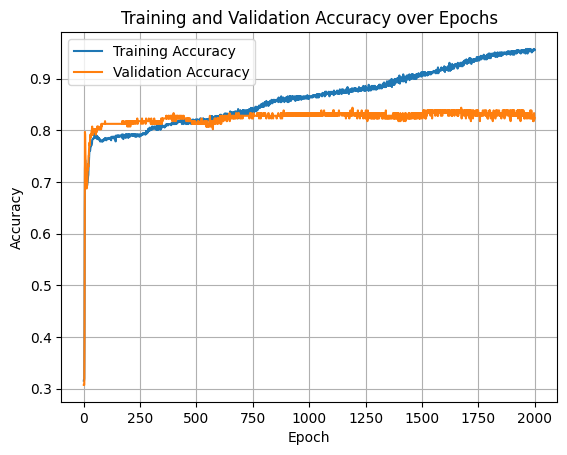

In [ ]:
# Instantiate the Model, Loss Function, and Optimizer
model = DiabetesModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Training the Model with Shuffle
epochs = 2000
batch_size = 30

train_accuracy_list = []
validation_accuracy_list = []

for epoch in range(epochs):
    # Shuffle the training data at the beginning of each epoch
    indices = torch.randperm(len(X_train_tensor))
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        train_predictions = (train_outputs >= 0.5).float()
        train_accuracy = torch.sum(train_predictions == y_train_tensor).item() / len(y_train_tensor)
        train_accuracy_list.append(train_accuracy)

    # Evaluate the Model on Validation Data
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        validation_accuracy = torch.sum(test_predictions == y_test_tensor).item() / len(y_test_tensor)
        validation_accuracy_list.append(validation_accuracy)





# Plot results
plt.plot(range(1, epochs+1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs+1), validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
Best Validation Accuracy: 0.8489583333333334
Best Hyperparameters: {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'weight_decay': 0.0001}
Epoch: 0, Train Accuracy: 0.6823266219239373, Validation Accuracy: 0.6927083333333334
Epoch: 150, Trai

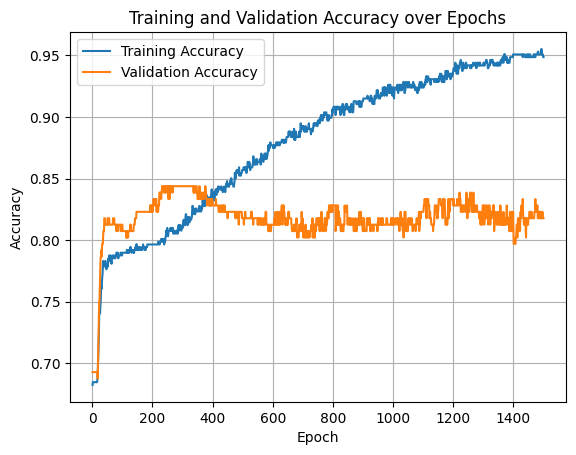

In [ ]:
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/diabetes.csv')
df.info()
df.shape

# Remove duplicates
df.drop_duplicates(inplace=True)

# Normalize features
features = df.drop('Outcome', axis=1)
labels = df['Outcome']

# Normalize features
features = (features - features.mean(axis=0)) / features.std(axis=0)

# Recombine features and labels
df = pd.concat([features, labels], axis=1)

# Check for outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Keep only rows that are within 1.5 * IQR
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Split the data into features and labels
features = df.drop('Outcome', axis=1).values
labels = df['Outcome'].values.reshape(-1, 1)

# Split the data into training and testing sets
split_ratio = 0.7
split_index = int(len(features) * split_ratio)

X_train, y_train = features[:split_index], labels[:split_index]
X_test, y_test = features[split_index:], labels[split_index:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network model
class DiabetesModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(DiabetesModel, self).__init__()
        self.lin1 = nn.Linear(8, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lin2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.lin3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        self.lin4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu1(self.lin1(x)))
        x = self.dropout2(self.relu2(self.lin2(x)))
        x = self.dropout3(self.relu3(self.lin3(x)))
        x = self.sigmoid(self.lin4(x))
        return x

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameter search space
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
dropout_rates = [0.1, 0.2, 0.3, 0.4]
weight_decays = [0.01, 0.001, 0.0001, 0.00001]

# Grid search over hyperparameters
best_val_accuracy = 0.0
best_hyperparams = {}

for lr, dropout_rate, weight_decay in itertools.product(learning_rates, dropout_rates, weight_decays):
    model = DiabetesModel(dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    epochs = 500  # Reduced for tuning
    batch_size = 29

    for epoch in range(epochs):
        model.train()
        indices = torch.randperm(len(X_train_tensor))
        X_train_tensor = X_train_tensor[indices]
        y_train_tensor = y_train_tensor[indices]

        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            targets = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluate the model on validation data
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        validation_accuracy = torch.sum(test_predictions == y_test_tensor).item() / len(y_test_tensor)

    if validation_accuracy > best_val_accuracy:
        best_val_accuracy = validation_accuracy
        best_hyperparams = {'learning_rate': lr, 'dropout_rate': dropout_rate, 'weight_decay': weight_decay}

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Best Hyperparameters: {best_hyperparams}")

# Train the final model with best hyperparameters
best_model = DiabetesModel(best_hyperparams['dropout_rate'])
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparams['learning_rate'], weight_decay=best_hyperparams['weight_decay'])

epochs = 1500
batch_size = 29

train_accuracy_list = []
validation_accuracy_list = []

for epoch in range(epochs):
    best_model.train()
    indices = torch.randperm(len(X_train_tensor))
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluate the model on training data
    best_model.eval()
    with torch.no_grad():
        train_outputs = best_model(X_train_tensor)
        train_predictions = (train_outputs >= 0.5).float()
        train_accuracy = torch.sum(train_predictions == y_train_tensor).item() / len(y_train_tensor)
        train_accuracy_list.append(train_accuracy)

    # Evaluate the model on validation data
    with torch.no_grad():
        test_outputs = best_model(X_test_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        validation_accuracy = torch.sum(test_predictions == y_test_tensor).item() / len(y_test_tensor)
        validation_accuracy_list.append(validation_accuracy)

    if epoch % (epochs // 10) == 0:
        print(f"Epoch: {epoch}, Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}")

# Plot results
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Epoch: 0, Train Acc: 0.3154, Valid Acc: 0.3073
Epoch: 200, Train Acc: 0.7852, Valid Acc: 0.8177
Epoch: 400, Train Acc: 0.7987, Valid Acc: 0.8229
Epoch: 600, Train Acc: 0.8098, Valid Acc: 0.8177
Epoch: 800, Train Acc: 0.8233, Valid Acc: 0.8177
Epoch: 1000, Train Acc: 0.8300, Valid Acc: 0.8125
Epoch: 1200, Train Acc: 0.8367, Valid Acc: 0.8125
Epoch: 1400, Train Acc: 0.8479, Valid Acc: 0.8229
Epoch: 1600, Train Acc: 0.8412, Valid Acc: 0.8125
Epoch: 1800, Train Acc: 0.8456, Valid Acc: 0.8073
Epoch: 1999, Train Acc: 0.8523, Valid Acc: 0.8177


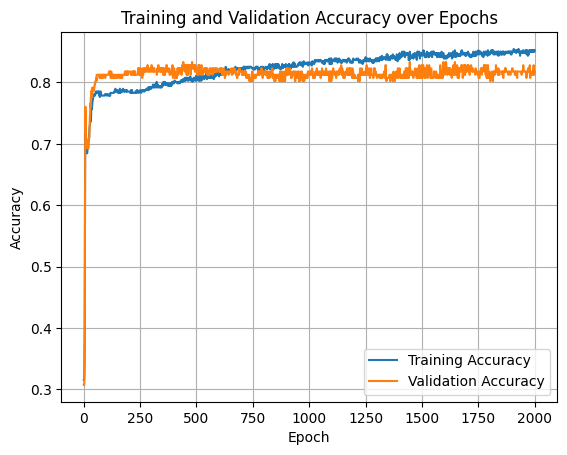

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and clean the dataset
df = pd.read_csv('/content/diabetes.csv')

# Remove duplicates
df.drop_duplicates(inplace=True)

# Normalize features
features = df.drop('Outcome', axis=1)
labels = df['Outcome']

# Normalize features
features = (features - features.mean(axis=0)) / features.std(axis=0)

# Recombine features and labels
df = pd.concat([features, labels], axis=1)

# Check for outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Keep only rows that are within 1.5 * IQR
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Split the data into features and labels
features = df.drop('Outcome', axis=1).values
labels = df['Outcome'].values.reshape(-1, 1)

# Split the data into training and testing sets
split_ratio = 0.7
split_index = int(len(features) * split_ratio)

X_train, y_train = features[:split_index], labels[:split_index]
X_test, y_test = features[split_index:], labels[split_index:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network model
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.lin1 = nn.Linear(8, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu1(self.lin1(x)))
        x = self.dropout2(self.relu2(self.lin2(x)))
        x = self.dropout3(self.relu3(self.lin3(x)))
        x = self.sigmoid(self.lin4(x))
        return x

# Instantiate the model, loss function, and optimizer
model = DiabetesModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Training the model with shuffling and batch processing
epochs = 2000
batch_size = 36

train_accuracy_list = []
validation_accuracy_list = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    # Shuffle the training data at the beginning of each epoch
    indices = torch.randperm(len(X_train_tensor))
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        train_predictions = (train_outputs >= 0.5).float()
        train_accuracy = torch.sum(train_predictions == y_train_tensor).item() / len(y_train_tensor)
        train_accuracy_list.append(train_accuracy)

        test_outputs = model(X_test_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        validation_accuracy = torch.sum(test_predictions == y_test_tensor).item() / len(y_test_tensor)
        validation_accuracy_list.append(validation_accuracy)


    if epoch % (epochs // 10) == 0:
        print(f"Epoch: {epoch}, Train Acc: {train_accuracy:.4f}, Valid Acc: {validation_accuracy:.4f}")

    if epoch == epochs-1:
          print(f"Epoch: {epoch}, Train Acc: {train_accuracy:.4f}, Valid Acc: {validation_accuracy:.4f}")

torch.save(model, '/content/diabeties_model.pth')

# Plot results
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Epoch: 0, Train Acc: 0.3177, Valid Acc: 0.3177
Epoch: 200, Train Acc: 0.7875, Valid Acc: 0.8177
Epoch: 400, Train Acc: 0.8009, Valid Acc: 0.8229
Epoch: 600, Train Acc: 0.8098, Valid Acc: 0.8281
Epoch: 800, Train Acc: 0.8188, Valid Acc: 0.8229
Epoch: 1000, Train Acc: 0.8233, Valid Acc: 0.8281
Epoch: 1200, Train Acc: 0.8300, Valid Acc: 0.8229
Epoch: 1400, Train Acc: 0.8367, Valid Acc: 0.8125
Epoch: 1600, Train Acc: 0.8434, Valid Acc: 0.8229
Epoch: 1800, Train Acc: 0.8456, Valid Acc: 0.8333
Epoch: 1999, Train Acc: 0.8523, Valid Acc: 0.8281


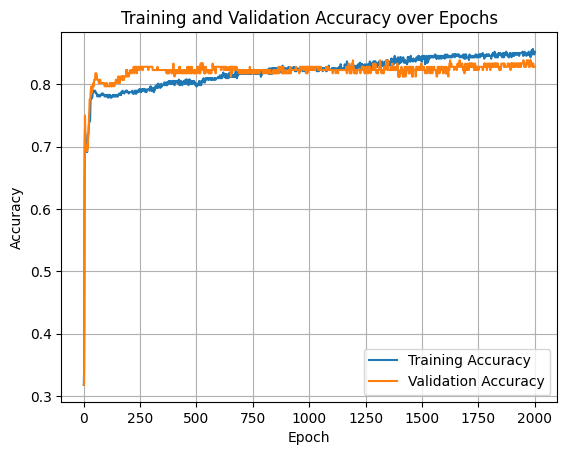

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and clean the dataset
df = pd.read_csv('/content/diabetes.csv')

# Remove duplicates
df.drop_duplicates(inplace=True)

# Normalize features
features = df.drop('Outcome', axis=1)
labels = df['Outcome']

# Normalize features
features = (features - features.mean(axis=0)) / features.std(axis=0)

# Recombine features and labels
df = pd.concat([features, labels], axis=1)

# Check for outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Keep only rows that are within 1.5 * IQR
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Split the data into features and labels
features = df.drop('Outcome', axis=1).values
labels = df['Outcome'].values.reshape(-1, 1)

# Split the data into training and testing sets
split_ratio = 0.7
split_index = int(len(features) * split_ratio)

X_train, y_train = features[:split_index], labels[:split_index]
X_test, y_test = features[split_index:], labels[split_index:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network model
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.lin1 = nn.Linear(8, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu1(self.lin1(x)))
        x = self.dropout2(self.relu2(self.lin2(x)))
        x = self.dropout3(self.relu3(self.lin3(x)))
        x = self.sigmoid(self.lin4(x))
        return x

# Instantiate the model, loss function, and optimizer
model = DiabetesModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Training the model with shuffling and batch processing
epochs = 2000
batch_size = 32

train_accuracy_list = []
validation_accuracy_list = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    # Shuffle the training data at the beginning of each epoch
    indices = torch.randperm(len(X_train_tensor))
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        train_predictions = (train_outputs >= 0.5).float()
        train_accuracy = torch.sum(train_predictions == y_train_tensor).item() / len(y_train_tensor)
        train_accuracy_list.append(train_accuracy)

        test_outputs = model(X_test_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        validation_accuracy = torch.sum(test_predictions == y_test_tensor).item() / len(y_test_tensor)
        validation_accuracy_list.append(validation_accuracy)


    if epoch % (epochs // 10) == 0:
        print(f"Epoch: {epoch}, Train Acc: {train_accuracy:.4f}, Valid Acc: {validation_accuracy:.4f}")

    if epoch == epochs-1:
          print(f"Epoch: {epoch}, Train Acc: {train_accuracy:.4f}, Valid Acc: {validation_accuracy:.4f}")

torch.save(model.state_dict(), '/content/diabeties_model_2.pth')

# Plot results
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Epoch: 0, Train Acc: 0.6734, Valid Acc: 0.6875
Epoch: 200, Train Acc: 0.7852, Valid Acc: 0.8229
Epoch: 400, Train Acc: 0.8076, Valid Acc: 0.8125
Epoch: 600, Train Acc: 0.8143, Valid Acc: 0.8229
Epoch: 800, Train Acc: 0.8210, Valid Acc: 0.8177
Epoch: 1000, Train Acc: 0.8255, Valid Acc: 0.8281
Epoch: 1200, Train Acc: 0.8322, Valid Acc: 0.8333
Epoch: 1400, Train Acc: 0.8456, Valid Acc: 0.8333
Epoch: 1600, Train Acc: 0.8434, Valid Acc: 0.8229
Epoch: 1800, Train Acc: 0.8412, Valid Acc: 0.8281
Epoch: 1999, Train Acc: 0.8479, Valid Acc: 0.8333


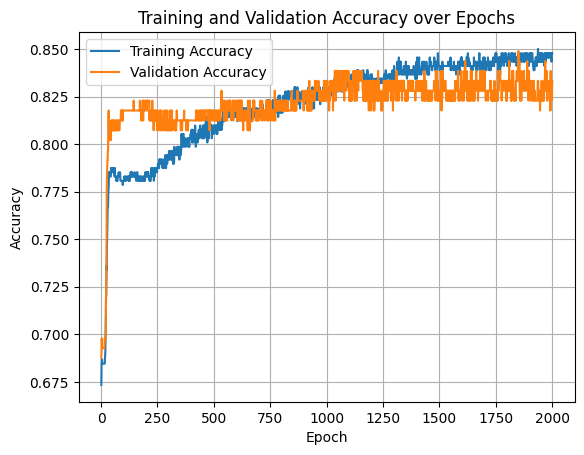

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and clean the dataset
df = pd.read_csv('/content/diabetes.csv')

# Check and handle missing values
# (If there were any, but diabetes.csv typically has no missing values)
# df.fillna(df.mean(), inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Normalize features
features = df.drop('Outcome', axis=1)
labels = df['Outcome']

# Normalize features
features = (features - features.mean(axis=0)) / features.std(axis=0)

# Recombine features and labels
df = pd.concat([features, labels], axis=1)

# Check for outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Keep only rows that are within 1.5 * IQR
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Split the data into features and labels
features = df.drop('Outcome', axis=1).values
labels = df['Outcome'].values.reshape(-1, 1)

# Split the data into training and testing sets
split_ratio = 0.7
split_index = int(len(features) * split_ratio)

X_train, y_train = features[:split_index], labels[:split_index]
X_test, y_test = features[split_index:], labels[split_index:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network model
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.lin1 = nn.Linear(8, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)  # Adjust dropout rate as needed
        self.lin4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu1(self.lin1(x)))
        x = self.dropout2(self.relu2(self.lin2(x)))
        x = self.dropout3(self.relu3(self.lin3(x)))
        x = self.sigmoid(self.lin4(x))
        return x

# Instantiate the model, loss function, and optimizer
model = DiabetesModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Training the model with shuffling and batch processing
epochs = 2000
batch_size = 30

train_accuracy_list = []
validation_accuracy_list = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    # Shuffle the training data at the beginning of each epoch
    indices = torch.randperm(len(X_train_tensor))
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        train_predictions = (train_outputs >= 0.5).float()
        train_accuracy = torch.sum(train_predictions == y_train_tensor).item() / len(y_train_tensor)
        train_accuracy_list.append(train_accuracy)

        test_outputs = model(X_test_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        validation_accuracy = torch.sum(test_predictions == y_test_tensor).item() / len(y_test_tensor)
        validation_accuracy_list.append(validation_accuracy)


    if epoch % (epochs // 10) == 0:
        print(f"Epoch: {epoch}, Train Acc: {train_accuracy:.4f}, Valid Acc: {validation_accuracy:.4f}")

    if epoch == epochs-1:
          print(f"Epoch: {epoch}, Train Acc: {train_accuracy:.4f}, Valid Acc: {validation_accuracy:.4f}")

torch.save(model, '/content/diabeties_model_3.pth')

# Plot results
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
Best Validation Accuracy: 0.8489583333333334
Best Hyperparameters: {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'weight_decay': 0.0001}
Epoch: 0, Train Accuracy: 0.6823266219239373, Validation Accuracy: 0.6927083333333334
Epoch: 150, Trai

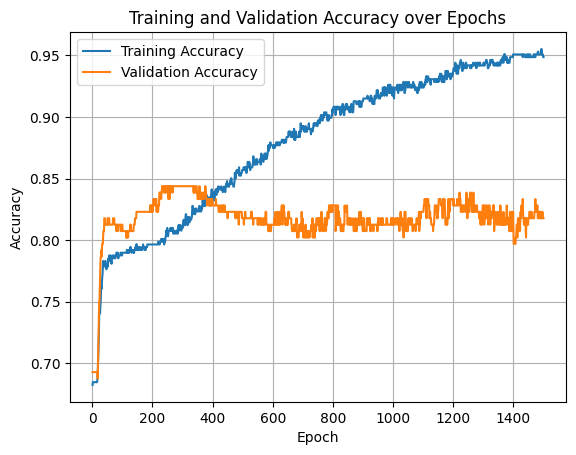

In [ ]:
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/diabetes.csv')
df.info()
df.shape

# Remove duplicates
df.drop_duplicates(inplace=True)

# Normalize features
features = df.drop('Outcome', axis=1)
labels = df['Outcome']

# Normalize features
features = (features - features.mean(axis=0)) / features.std(axis=0)

# Recombine features and labels
df = pd.concat([features, labels], axis=1)

# Check for outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Keep only rows that are within 1.5 * IQR
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Split the data into features and labels
features = df.drop('Outcome', axis=1).values
labels = df['Outcome'].values.reshape(-1, 1)

# Split the data into training and testing sets
split_ratio = 0.7
split_index = int(len(features) * split_ratio)

X_train, y_train = features[:split_index], labels[:split_index]
X_test, y_test = features[split_index:], labels[split_index:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network model
class DiabetesModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(DiabetesModel, self).__init__()
        self.lin1 = nn.Linear(8, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lin2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.lin3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        self.lin4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu1(self.lin1(x)))
        x = self.dropout2(self.relu2(self.lin2(x)))
        x = self.dropout3(self.relu3(self.lin3(x)))
        x = self.sigmoid(self.lin4(x))
        return x

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameter search space
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
dropout_rates = [0.1, 0.2, 0.3, 0.4]
weight_decays = [0.01, 0.001, 0.0001, 0.00001]

# Grid search over hyperparameters
best_val_accuracy = 0.0
best_hyperparams = {}

for lr, dropout_rate, weight_decay in itertools.product(learning_rates, dropout_rates, weight_decays):
    model = DiabetesModel(dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    epochs = 500  # Reduced for tuning
    batch_size = 29

    for epoch in range(epochs):
        model.train()
        indices = torch.randperm(len(X_train_tensor))
        X_train_tensor = X_train_tensor[indices]
        y_train_tensor = y_train_tensor[indices]

        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            targets = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluate the model on validation data
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        validation_accuracy = torch.sum(test_predictions == y_test_tensor).item() / len(y_test_tensor)

    if validation_accuracy > best_val_accuracy:
        best_val_accuracy = validation_accuracy
        best_hyperparams = {'learning_rate': lr, 'dropout_rate': dropout_rate, 'weight_decay': weight_decay}

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Best Hyperparameters: {best_hyperparams}")

# Train the final model with best hyperparameters
best_model = DiabetesModel(best_hyperparams['dropout_rate'])
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparams['learning_rate'], weight_decay=best_hyperparams['weight_decay'])

epochs = 1500
batch_size = 29

train_accuracy_list = []
validation_accuracy_list = []

for epoch in range(epochs):
    best_model.train()
    indices = torch.randperm(len(X_train_tensor))
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluate the model on training data
    best_model.eval()
    with torch.no_grad():
        train_outputs = best_model(X_train_tensor)
        train_predictions = (train_outputs >= 0.5).float()
        train_accuracy = torch.sum(train_predictions == y_train_tensor).item() / len(y_train_tensor)
        train_accuracy_list.append(train_accuracy)

    # Evaluate the model on validation data
    with torch.no_grad():
        test_outputs = best_model(X_test_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        validation_accuracy = torch.sum(test_predictions == y_test_tensor).item() / len(y_test_tensor)
        validation_accuracy_list.append(validation_accuracy)

    if epoch % (epochs // 10) == 0:
        print(f"Epoch: {epoch}, Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}")

# Plot results
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
